# CSCI 6515 -- Machine Learning for Big Data

### Assignment 1 -- Predicting Subject's Headaches Based on Weather Conditions

**Group Members (5):**  
    - Abhijeet Singh  
    - Tayab Soomro  
    - Rashidul Islam  
    - Shrey Rameshbhai Vaghela  
    - Dhruv Tarpara  

## Introduction

This notebook contains the code, as well as the results pertaining to the decision tree model that was used to predict the subject's headaches based on the weather conditions. The notebook is organized into following sections.


1. [Library Imports](#1-library-imports)  
2. [Data Preparation](#2-data-preparation)  
    2.1 [Training Set](#21-training-set)  
    2.2 [Data Preparation for Prediction Set](#22-prediction-set)  
3. [Descriptive Analysis](#3-descriptive-analysis)  
    3.1 [Mean, Median, Standard Deviation](#31-mean-median-standard-deviation)  
    3.2 [Distribution of Headache Classes](#32-distribution-of-headache-classes)  
    3.3 [Headache Distribution By Days of Week](#33-headache-distribution-by-days-of-week)  
    3.4 [Hours of Headache Distributed By Days of Week](#34-hours-of-headache-distributed-by-days-of-week)  
    3.5 [Headache Distribution By Temperature Range](#35-headache-distribution-by-temperature-range)  
    3.6 [Headache Distribution By Humidity Range](#36-headache-distribution-by-temperature-range)  
    3.7 [Headache Distribution By Wind Speed](#37-headache-distribution-by-wind-speed)  
    3.8 [Numerical Features Histogram](#38-numerical-features-histogram)  
4. [Feature Selection](#4-feature-selection)  
    4.1 [Correlation Analysis of Training Set](#41-correlation-analysis-of-traning-set)  
    4.2 [Finalized Features](#42-finalized-features)  
    
5. [Model Building](#5-model-building)  
    5.1 [Feature Engineering](#51-feature-engineering)  
    5.2 [Decision Tree With Default Parameters](#52-base-line-decision-tree)  
    5.3 [Decision Tree With Hyperparameter Tuning With Class Weight As Balanced](#53-decision-tree-with-hyperparameter-tuning-with-class-weight-as-balanced)  
    5.4 [Decision Tree With Oversampling of Training Data](#54-decision-tree-with-oversampling-of-traning-data)  
    5.5 [Decision Tree With Undersampling of Traning Data](#55-decision-tree-with-undersampling-of-traning-data)  
6. [Results Evaluation](#6-results-evaluation)  

## 1. Library Imports

In [ ]:
import pandas as pd
import statistics
import warnings
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score, confusion_matrix
from imblearn.under_sampling import NearMiss
from numpy import savetxt
warnings.filterwarnings('ignore')


## 2. Data Preparation

#### Function for dropping unnecessary columns

In [ ]:
## Function written to drop the unnecessary weather data columns
def drop(data):
    data = data.drop(["Time","Temp Flag","Dew Point Temp Flag","Rel Hum Flag","Wind Dir Flag","Wind Spd Flag","Visibility (km)","Visibility Flag","Stn Press Flag","Hmdx","Hmdx Flag","Wind Chill","Wind Chill Flag","Longitude (x)","Latitude (y)","Station Name","Climate ID","Weather","Stn Press (kPa)","Wind Dir (10s deg)"],axis = 1)
    return(data)

#### Function for calulating average for each day (weather Data)

In [ ]:
## Function written for calculating the average of each day for the weather data
def average(data):
    data = round(data.groupby(["Day","Month","Year"]).mean(),2)
    data["Date"] = data.index
    data.reset_index(drop = True, inplace = True)

    k = 0
    for i in data["Date"]:
        l = []
        for j in i:
            l.append(str(j))
        if len(l[0]) < 2:
            l[0] = "0"+l[0]
        if len (l[1]) < 2:
            l[1] = "0" + l[1]
        l[0],l[-1] = l[-1],l[0]
        date = "-".join(l)
        date_object = datetime.strptime(date, '%Y-%m-%d').date()
        data["Date"][k] = date_object
        k = k + 1
        
    data = data[["Date","Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)","Wind Spd (km/h)"]]
    return(data)
        
    

#### Function for calulating combine weather data average for all station

In [ ]:
## Function written for calculating the combine weather average data for all station
def average_1 (ns_w,ns_s1, ns_s2,ns_d, ns_k):
    data = pd.DataFrame(columns = ["Date","Temp","Dew_Point_Temp","Humidity","Wind_Spd"])
    
    data["Date"] = ns_w["Date"]
    k = 0
    for i in ns_w["Date"]:
        data["Temp"][k] = statistics.median((ns_w["Temp (°C)"][k],ns_s2["Temp (°C)"][k],ns_k["Temp (°C)"][k],ns_d["Temp (°C)"][k]))
        data["Dew_Point_Temp"][k] = statistics.median((ns_w["Dew Point Temp (°C)"][k],ns_s2["Dew Point Temp (°C)"][k],ns_k["Dew Point Temp (°C)"][k],ns_d["Dew Point Temp (°C)"][k]))
        data["Humidity"][k] = statistics.median((ns_w["Rel Hum (%)"][k],ns_s2["Rel Hum (%)"][k],ns_k["Rel Hum (%)"][k],ns_d["Rel Hum (%)"][k]))
        data["Wind_Spd"][k] = statistics.median((ns_w["Wind Spd (km/h)"][k],ns_s2["Wind Spd (km/h)"][k],ns_k["Wind Spd (km/h)"][k],ns_d["Wind Spd (km/h)"][k]))
        
        k = k + 1
    return(data)
        
        
        
        

### 2.1 Training Set

In [ ]:
#### Lodaing the data for all the stations for the year 2019(September to December)

ns_w_sep = pd.read_csv("./Data/Hourly_Data_2019/weather_sept_Hali_w_2019H.csv")
ns_w_oct = pd.read_csv("./Data/Hourly_Data_2019/weather_octo_Hali_w_2019H.csv")
ns_w_nov = pd.read_csv("./Data/Hourly_Data_2019/weather_nove_Hali_w_2019H.csv")
ns_w_dec = pd.read_csv("./Data/Hourly_Data_2019/weather_Dece_Hali_w_2019H.csv")

ns_s1_sep = pd.read_csv("./Data/Hourly_Data_2019/weather_sept_Hali_s1_2019H.csv")
ns_s1_oct = pd.read_csv("./Data/Hourly_Data_2019/weather_octo_Hali_s1_2019H.csv")
ns_s1_nov = pd.read_csv("./Data/Hourly_Data_2019/weather_nove_Hali_s1_2019H.csv")
ns_s1_dec = pd.read_csv("./Data/Hourly_Data_2019/weather_Dece_Hali_s1_2019H.csv")


ns_s2_sep = pd.read_csv("./Data/Hourly_Data_2019/weather_sept_Hali_s2_2019H.csv")
ns_s2_oct = pd.read_csv("./Data/Hourly_Data_2019/weather_octo_Hali_s2_2019H.csv")
ns_s2_nov = pd.read_csv("./Data/Hourly_Data_2019/weather_nove_Hali_s2_2019H.csv")
ns_s2_dec = pd.read_csv("./Data/Hourly_Data_2019/weather_Dece_Hali_s2_2019H.csv")


ns_d_sep = pd.read_csv("./Data/Hourly_Data_2019/weather_sept_Hali_D_2019H.csv")
ns_d_oct = pd.read_csv("./Data/Hourly_Data_2019/weather_octo_Hali_D_2019H.csv")
ns_d_nov = pd.read_csv("./Data/Hourly_Data_2019/weather_nove_Hali_D_2019H.csv")
ns_d_dec = pd.read_csv("./Data/Hourly_Data_2019/weather_Dece_Hali_D_2019H.csv")

ns_k_sep = pd.read_csv("./Data/Hourly_Data_2019/weather_sept_Hali_k_2019H.csv")
ns_k_oct = pd.read_csv("./Data/Hourly_Data_2019/weather_octo_Hali_k_2019H.csv")
ns_k_nov = pd.read_csv("./Data/Hourly_Data_2019/weather_nove_Hali_k_2019H.csv")
ns_k_dec = pd.read_csv("./Data/Hourly_Data_2019/weather_Dece_Hali_k_2019H.csv")


#### Dropping Unnecessary columns and calculating mean for Halifax Windsor Station 2019

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_w_sep = drop(ns_w_sep)
ns_w_sep = average(ns_w_sep)
ns_w_oct = drop(ns_w_oct)
ns_w_oct = average(ns_w_oct)
ns_w_nov = drop(ns_w_nov)
ns_w_nov = average(ns_w_nov)
ns_w_dec = drop(ns_w_dec)
ns_w_dec = average(ns_w_dec)

In [ ]:
## This is the code for concatinating the data for required months
ns_w = pd.concat([ns_w_sep,ns_w_oct,ns_w_nov,ns_w_dec])
ns_w = ns_w.reset_index()
ns_w_2019 = ns_w.drop(["index"],axis = 1)

#### Dropping Unnecessary columns and calculating mean for Halifax stanfield Station 1 2019

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_s1_sep = drop(ns_s1_sep)
ns_s1_sep = average(ns_s1_sep)
ns_s1_oct = drop(ns_s1_oct)
ns_s1_oct = average(ns_s1_oct)
ns_s1_nov = drop(ns_s1_nov)
ns_s1_nov = average(ns_s1_nov)
ns_s1_dec = drop(ns_s1_dec)
ns_s1_dec = average(ns_s1_dec)

In [ ]:
## This is the code for concatinating the data for required months
ns_s1 = pd.concat([ns_s1_sep,ns_s1_oct,ns_s1_nov,ns_s1_dec])
ns_s1 = ns_s1.reset_index()
ns_s1_2019 = ns_s1.drop(["index"],axis = 1)

#### Dropping Unnecessary columns and calculating mean for Halifax stanfield Station 2 2019

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_s2_sep = drop(ns_s2_sep)
ns_s2_sep = average(ns_s2_sep)
ns_s2_oct = drop(ns_s2_oct)
ns_s2_oct = average(ns_s2_oct)
ns_s2_nov = drop(ns_s2_nov)
ns_s2_nov = average(ns_s2_nov)
ns_s2_dec = drop(ns_s2_dec)
ns_s2_dec = average(ns_s2_dec)

In [ ]:
## This is the code for concatinating the data for required months
ns_s2 = pd.concat([ns_s2_sep,ns_s2_oct,ns_s2_nov,ns_s2_dec])
ns_s2 = ns_s2.reset_index()
ns_s2_2019 = ns_s2.drop(["index"],axis = 1)

#### Dropping Unnecessary columns and calculating mean for Halifax Dockyard Station 2019

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_d_sep = drop(ns_d_sep)
ns_d_sep = average(ns_d_sep)
ns_d_oct = drop(ns_d_oct)
ns_d_oct = average(ns_d_oct)
ns_d_nov = drop(ns_d_nov)
ns_d_nov = average(ns_d_nov)
ns_d_dec = drop(ns_d_dec)
ns_d_dec = average(ns_d_dec)

In [ ]:
## This is the code for concatinating the data for required months
ns_d = pd.concat([ns_d_sep,ns_d_oct,ns_d_nov,ns_d_dec])
ns_d = ns_d.reset_index()
ns_d_2019 = ns_d.drop(["index"],axis = 1)

#### Dropping Unnecessary columns and calculating mean for Halifax Kettonie Station 2019

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_k_sep = drop(ns_k_sep)
ns_k_sep = average(ns_k_sep)
ns_k_oct = drop(ns_k_oct)
ns_k_oct = average(ns_k_oct)
ns_k_nov = drop(ns_k_nov)
ns_k_nov = average(ns_k_nov)
ns_k_dec = drop(ns_k_dec)
ns_k_dec = average(ns_k_dec)

In [ ]:
## This is the code for concatinating the data for required months
ns_k = pd.concat([ns_k_sep,ns_k_oct,ns_k_nov,ns_k_dec])
ns_k = ns_k.reset_index()
ns_k_2019 = ns_k.drop(["index"], axis = 1)

In [ ]:
print("shape of Halifax windsor station :", ns_w_2019.shape)
print("shape of Halifax Stanfield 2 station :", ns_s1_2019.shape)
print("shape of Halifax Stanfield 2 station :", ns_s2_2019.shape)
print("shape of Halifax Dockyard station :", ns_d_2019.shape)
print("shape of Halifax kettonie station :", ns_k_2019.shape)

#### Taking average of all the station combined weather data 2019

In [ ]:
## This code calulates the average of all the station combined by calling the above function
station_2019 = average_1(ns_w_2019,ns_s1_2019, ns_s2_2019,ns_d_2019, ns_k_2019)

In [ ]:
# checking the null values in the station data
station_2019.isna().sum()

In [ ]:
station_2019.head(2)

#### Loading journal Data

In [ ]:
journal_train = pd.read_excel("./Data/Combined_Journal_data1.xlsx")

In [ ]:
journal_train.shape

In [ ]:
journal_train.columns

#### Combining Journal and Station Data

In [ ]:
#### Combining the journal data and station data to have the dataset for traning and test set

data_journal_weather_2019 = station_2019.set_index("Date").join(journal_train.set_index("Date"))
data_journal_weather_2019["Date"] = data_journal_weather_2019.index
data_journal_weather_2019.reset_index(drop = True, inplace = True)
data_journal_weather_2019.columns
data_journal_weather_2019= data_journal_weather_2019[["Date",'Days','Temp','Dew_Point_Temp','Humidity','Wind_Spd','Severity of Headache','No. of hours Headache', 'No. of Hours Workout','Headache']]

In [ ]:
print("shape of the journal and station data:", data_journal_weather_2019.shape)

In [ ]:
data_journal_weather_2019.head(2)

In [ ]:
# Checking Null Values
data_journal_weather_2019.isnull().sum()

In [ ]:
# Replacing Null Values in the dataset

data_journal_weather_2019["Severity of Headache"] = data_journal_weather_2019["Severity of Headache"].replace(np.nan,0)
data_journal_weather_2019["No. of hours Headache"] = data_journal_weather_2019["No. of hours Headache"].replace(np.nan,0)
data_journal_weather_2019["No. of Hours Workout"] = data_journal_weather_2019["No. of Hours Workout"].replace(np.nan,0)

In [ ]:
# Saving the data
data_journal_weather_2019.to_excel("model_data.xls",index = False)

In [7]:
data_journal_weather_2019 = pd.read_excel("model_data.xls")

### 2.2  Prediction Set

In [8]:
# In this code data is loaded for sept2020
ns_w_sep = pd.read_csv("./Data/Hourly_Data_2020/weather_sept_Hali_w_2020H.csv")
ns_s1_sep = pd.read_csv("./Data/Hourly_Data_2020/weather_sept_Hali_s1_2020H.csv")
ns_s2_sep = pd.read_csv("./Data/Hourly_Data_2020/weather_sept_Hali_s2_2020H.csv")
ns_d_sep = pd.read_csv("./Data/Hourly_Data_2020/weather_sept_Hali_D_2020H.csv")
ns_k_sep = pd.read_csv("./Data/Hourly_Data_2020/weather_sept_Hali_k_2020H.csv")

#### Dropping Unnecessary columns and calculating mean for Halifax Windsor Station 2020

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_w_sep = drop(ns_w_sep)
ns_w_sep_2020 = average(ns_w_sep)

#### Dropping Unnecessary columns and calculating mean for Halifax stanfield Station1 2020

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_s1_sep = drop(ns_s1_sep)
ns_s1_sep_2020 = average(ns_s1_sep)

#### Dropping Unnecessary columns and calculating mean for Halifax stanfield Station 2 2020

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_s2_sep = drop(ns_s2_sep)
ns_s2_sep_2020 = average(ns_s2_sep)

#### Dropping Unnecessary columns and calculating mean for Halifax Dockyard Station 2020

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_d_sep = drop(ns_d_sep)
ns_d_sep_2020 = average(ns_d_sep)

#### Dropping Unnecessary columns and calculating mean for Halifax Kettonie Station 2020

In [ ]:
## With this code above functions are being called to drop and to take the average
ns_k_sep = drop(ns_k_sep)
ns_k_sep_2020 = average(ns_k_sep)

In [ ]:
print("shape of Halifax windsor station :", ns_w_sep_2020.shape)
print("shape of Halifax Stanfield 2 station :", ns_s2_sep_2020.shape)
print("shape of Halifax Dockyard station :", ns_d_sep_2020.shape)
print("shape of Halifax kettonie station :", ns_k_sep_2020.shape)

#### Taking average of all the station combined weather data 2020

In [ ]:
# With this code above function are called for calculating the average combined of all the station weather's data 2020
station_2020 = average_1(ns_w_sep_2020,ns_s1_sep_2020,ns_s2_sep_2020,ns_d_sep_2020,ns_k_sep_2020)

In [ ]:
# checking the null values in the station data
station_2020.isna().sum()

In [ ]:
station_2020.head(2)

In [ ]:
station_2020.to_excel("prediction_Set.xls", index = False)

In [ ]:
## Loading the journal data for sept2020 same as before
journal_data = pd.read_excel("./Data/student_workout_work_schdule_2020.xlsx")

#### Combining weather and journal data for prediction set sept 2020

In [ ]:
## Combining journal and weather data for sept 2020
prediction_data_journal_weather_2020 = station_2020.set_index("Date").join(journal_data.set_index("Date"))
prediction_data_journal_weather_2020["Date"] = prediction_data_journal_weather_2020.index
prediction_data_journal_weather_2020.reset_index(drop = True, inplace = True)
prediction_data_journal_weather_2020= prediction_data_journal_weather_2020[["Date",'Temp','Dew_Point_Temp','Humidity','Wind_Spd', 'Work Schdule hours',
        'No. of Hours Workout']]

In [43]:
prediction_data_journal_weather_2020.to_csv("prediction_data_journal_weather_2020.csv", index = False)

In [43]:
prediction_data_journal_weather_2020.head(2)

,Date,Temp,Dew_Point_Temp,Humidity,Wind_Spd,Work Schdule hours,No. of Hours Workout
0,2020-09-01,14.625,9.145,69.475,6.935,0,NaN
1,2020-09-02,14.315,12.72,90.415,9.705,8,1.0


In [44]:
prediction_data_journal_weather_2020.isna().sum()

Date                     0
Temp                     0
Dew_Point_Temp           0
Humidity                 0
Wind_Spd                 0
Work Schdule hours       0
No. of Hours Workout    26
dtype: int64

In [45]:
##Replacing the mising values in No.of hours of workout
prediction_data_journal_weather_2020["No. of Hours Workout"] = prediction_data_journal_weather_2020["No. of Hours Workout"].replace(np.nan,0)

In [46]:
prediction_data_journal_weather_2020.isna().sum()

Date                    0
Temp                    0
Dew_Point_Temp          0
Humidity                0
Wind_Spd                0
Work Schdule hours      0
No. of Hours Workout    0
dtype: int64

## 3. Descriptive Analysis

### 3.1 Mean, Median, Standard Deviation

In [47]:
data_journal_weather_2019.head()

,Date,Days,Temp,Dew_Point_Temp,Humidity,Wind_Spd,Severity of Headache,Work Schdule hours,No. of hours Headache,No. of Hours Workout,Headache
0,2019-09-01,Sunday,17.935,10.19,63.730,10.915,0.0,0,0,0,0
1,2019-09-02,Monday,17.650,15.23,86.580,12.850,0.0,8,0,1,0
2,2019-09-03,Tuesday,19.960,17.50,86.355,8.520,0.0,8,0,0,0
3,2019-09-04,Wednesday,19.410,17.45,88.915,11.540,0.0,8,0,1,0
4,2019-09-05,Thursday,19.705,13.25,68.250,13.415,0.8,8,3,0,1


In [48]:
data_journal_weather_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   122 non-null    datetime64[ns]
 1   Days                   122 non-null    object        
 2   Temp                   122 non-null    float64       
 3   Dew_Point_Temp         122 non-null    float64       
 4   Humidity               122 non-null    float64       
 5   Wind_Spd               122 non-null    float64       
 6   Severity of Headache   122 non-null    float64       
 7   Work Schdule hours     122 non-null    int64         
 8   No. of hours Headache  122 non-null    int64         
 9   No. of Hours Workout   122 non-null    int64         
 10  Headache               122 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(4), object(1)
memory usage: 10.6+ KB


- There is one feature with datetime datatype
- There is also one feature (Days) categorical datatype and all the other feature are of integer or float data type 

In [49]:
data_journal_weather_2019.describe()

,Temp,Dew_Point_Temp,Humidity,Wind_Spd,Severity of Headache,Work Schdule hours,No. of hours Headache,No. of Hours Workout,Headache
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,7.304795,3.328156,77.031393,16.187746,0.059016,5.377049,0.475410,0.122951,0.081967
std,6.957861,7.175483,9.502067,6.794198,0.203585,3.770981,1.855139,0.329735,0.275446
min,-7.015000,-11.840000,45.435000,6.225000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.301250,-0.581250,69.862500,11.431250,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.520000,3.822500,76.082500,14.315000,0.000000,8.000000,0.000000,0.000000,0.000000
75%,12.543750,9.667500,84.052500,18.816250,0.000000,8.000000,0.000000,0.000000,0.000000
max,19.960000,17.500000,95.975000,38.520000,1.000000,8.000000,14.000000,1.000000,1.000000


##### Description

- Mean and std deviation of Humidity are 77.03 and 9.5 respectively
- Mean and std deviation of wind direction are 23.04 and 6.4 respectively
- Mean and std deviation of wind speed are 16.18 and 6.7 respectively
- Mean and std deviation of stn press are 100.83 and 0.96 respectively
- Mean and std deviation of Number of hours working in the office are 5.377 and 3.77 respectively
- Mean and std deviation of Number of hours headache are 0.47 and 1.8 respectively
- Mean and std deviation of Number of workout hours are 0.081 and 0.27 respectively

#### Median of Numerical datatype

In [50]:
temp_median = data_journal_weather_2019["Temp"].median()
Dew_Point_Temp_median = data_journal_weather_2019["Dew_Point_Temp"].median()
Humidity_median = data_journal_weather_2019["Humidity"].median()
No_of_office_working_hours_median = data_journal_weather_2019["Work Schdule hours"].median()
No_of_Hours_Workout_median = data_journal_weather_2019["No. of Hours Workout"].median()


print("Median of Temp :", temp_median)
print("Median of Dew_Point_Temp :", Dew_Point_Temp_median)
print("Median of Humidity:", Humidity_median)
print("Median of Work Schdule hours  :", No_of_office_working_hours_median)
print("Median of No_of_Hours_Workout :", No_of_Hours_Workout_median)

Median of Temp : 7.52
Median of Dew_Point_Temp : 3.8225000000000002
Median of Humidity: 76.0825
Median of Work Schdule hours  : 8.0
Median of No_of_Hours_Workout : 0.0


### 3.2 Distribution of Headache Classes

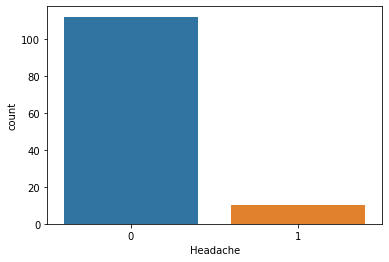

In [51]:
ax = sns.countplot(x="Headache", data = data_journal_weather_2019)

- Here 0 indicates no headache and 1 indicates that student has headache
- After seeing above graph we can confirm that our data set is imbalanced 

### 3.3 Headache Distribution By Days of Week

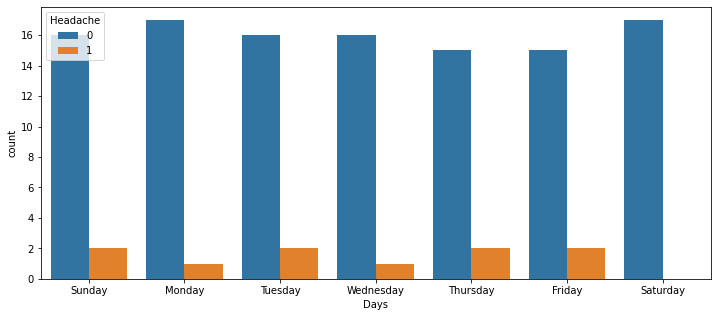

In [52]:
plt.figure(figsize = (12,5))
ax = sns.countplot(x="Days", hue = data_journal_weather_2019["Headache"],data = data_journal_weather_2019)

- From above graph we can see that student was having headache mostly on week days with friday tuesday and sunday being among the heighest

### 3.4 Hours of Headache Distributed By Days of Week

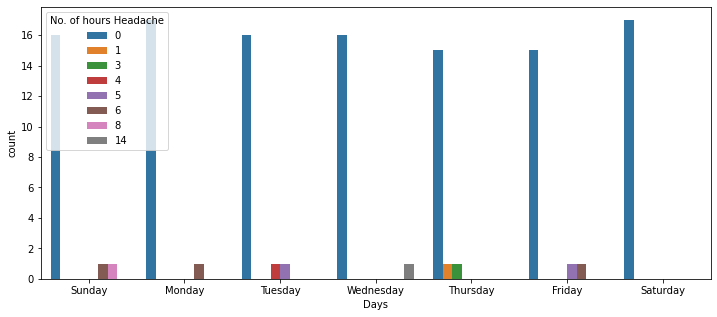

In [53]:
plt.figure(figsize = (12,5))
ax = sns.countplot(x="Days", hue = data_journal_weather_2019["No. of hours Headache"],data = data_journal_weather_2019)

- The student had maximum hours of headache on wednesday of 14 hours(Severe Headache)

### 3.5 Headache Distribution By Temperature Range

In [ ]:
bins = [-8,-7,-3,0,3,7,10,13,19, np.inf]
names = ["-8_-7","-7_-3","-3_0","0_3","3_7","7_10","10_13","13_19","19+"]
data = pd.DataFrame(columns = ['Temp_range', "Headache"])
data["Headache"] = data_journal_weather_2019["Headache"]
data["Temp_range"] = pd.cut(data_journal_weather_2019["Temp"], bins, labels = names)

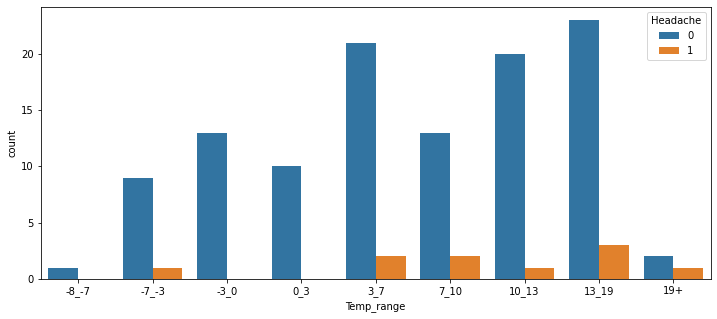

In [55]:
plt.figure(figsize = (12,5))
ax = sns.countplot(x="Temp_range", hue = data["Headache"],data = data)

- From the above graph we can see that the student was having more headaches between 13-19 degree celcius Temperature

### 3.6 Headache Distribution By Humidity Range

In [56]:
bins = [30,40,50,60,65,70,75,80,85,90, 94, np.inf]
names = ["30-40","40-50","50-60","60-65","65-70","70-75","75-80","80-85","85-90","90-95","95+"]
data = pd.DataFrame(columns = ['Humidity_range', "Headache"])
data["Headache"] = data_journal_weather_2019["Headache"]
data["Humidity_range"] = pd.cut(data_journal_weather_2019["Humidity"], bins, labels = names)

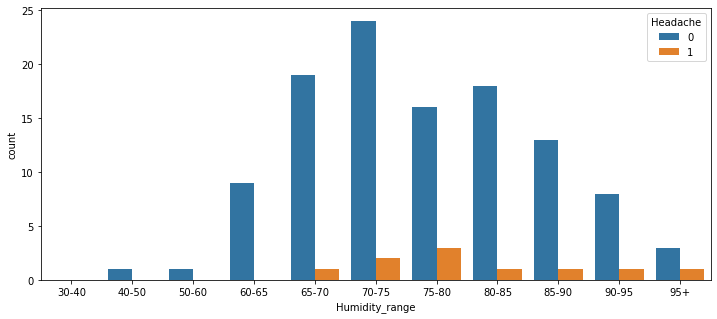

In [57]:
plt.figure(figsize = (12,5))
ax = sns.countplot(x="Humidity_range", hue = data["Headache"],data = data)

- From the above graph we can see that the student was having more headaches between 75-80 percentage of humidity

### 3.7 Headache Distribution By Wind Speed

In [58]:
bins = [6,10,15,20,25,30,35 ,np.inf]
names = ["6-10","10-15","15-20","20-25","25-30","30-35","35+"]
data = pd.DataFrame(columns = ['wind_spd_range', "Headache"])
data["Headache"] = data_journal_weather_2019["Headache"]
data["wind_spd_range"] = pd.cut(data_journal_weather_2019["Wind_Spd"], bins, labels = names)

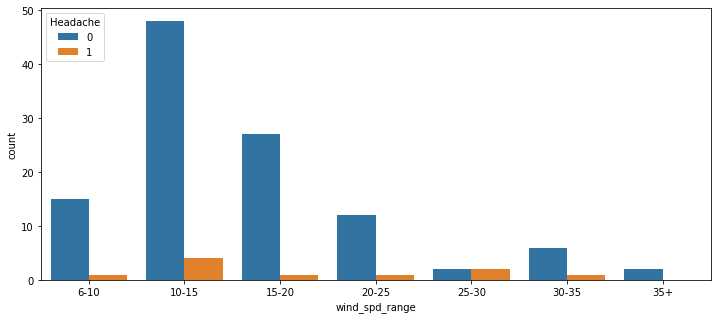

In [59]:
plt.figure(figsize = (12,5))
ax = sns.countplot(x="wind_spd_range", hue = data["Headache"],data = data)

- From the above graph we can see that the student had the maximum number of headache when wind speed was in range between 10-15

### 3.8 Numerical Features Histogram

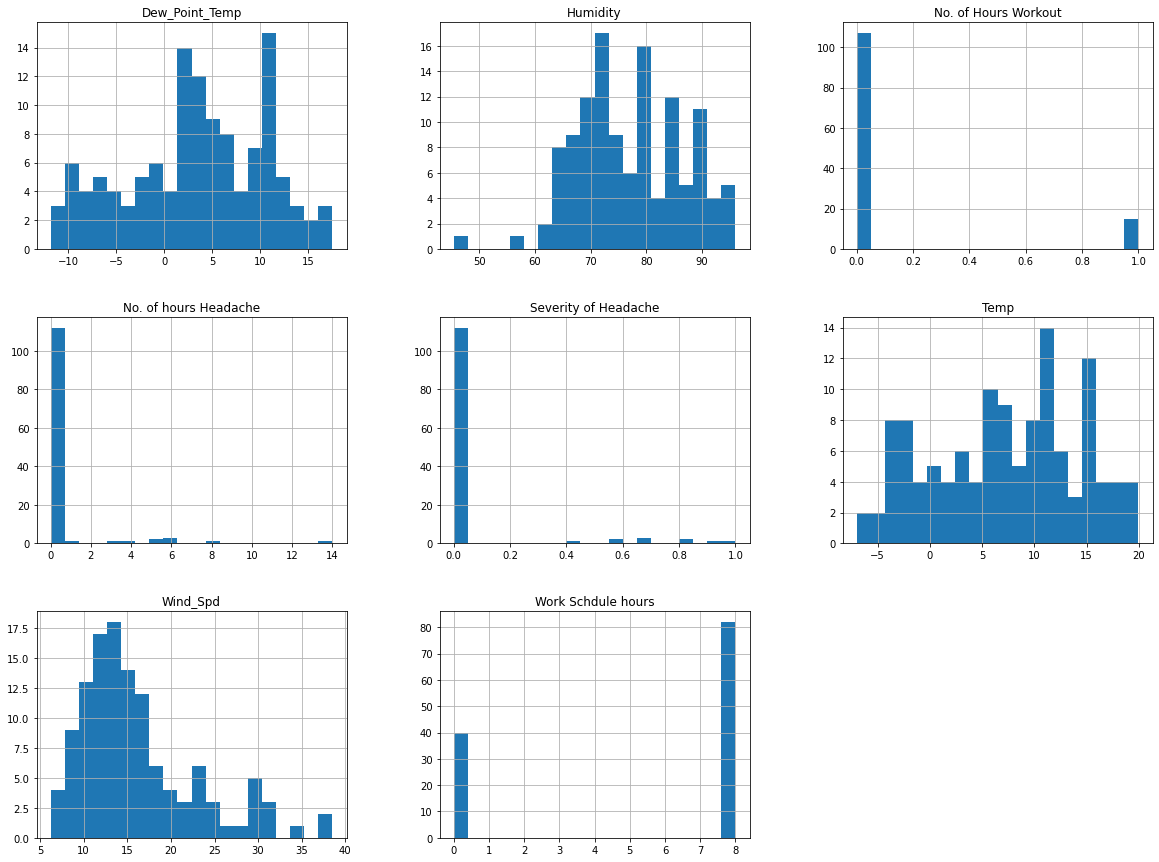

In [60]:
data = data_journal_weather_2019
data = data.drop(["Date", "Headache"],axis = 1)
num_bins = 20
data.hist(bins = num_bins, figsize =(20,15))
plt.show()

-  The above histogram shows the features such as Dew_point_temp, Humidity, Temp, Wind_Spd, stn_press , and Wind_dir have good distribution but some of them are slightly skewed
- Other features such as No. of office working hours, No. of hours of work_out, does not show good distribution

## 4 Feature Selection

### 4.1 Correlation Analysis of Training Set

In [61]:
data = data_journal_weather_2019
data = data.drop(["Date"],axis = 1)

,Temp,Dew_Point_Temp,Humidity,Wind_Spd,Severity of Headache,Work Schdule hours,No. of hours Headache,No. of Hours Workout,Headache
Temp,1.000000,0.965405,0.158414,-0.127300,0.117364,0.030457,0.113127,0.106350,0.124870
Dew_Point_Temp,0.965405,1.000000,0.408089,-0.073999,0.117851,0.070704,0.107427,0.080121,0.137563
Humidity,0.158414,0.408089,1.000000,0.146586,0.043254,0.160410,0.020539,-0.076695,0.091969
Wind_Spd,-0.127300,-0.073999,0.146586,1.000000,0.083495,-0.017742,0.049391,-0.029461,0.129182
Severity of Headache,0.117364,0.117851,0.043254,0.083495,1.000000,0.031060,0.898858,0.149552,0.974143
Work Schdule hours,0.030457,0.070704,0.160410,-0.017742,0.031060,1.000000,-0.009296,-0.057531,0.017739
No. of hours Headache,0.113127,0.107427,0.020539,0.049391,0.898858,-0.009296,1.000000,0.173865,0.861168
No. of Hours Workout,0.106350,0.080121,-0.076695,-0.029461,0.149552,-0.057531,0.173865,1.000000,0.161104
Headache,0.124870,0.137563,0.091969,0.129182,0.974143,0.017739,0.861168,0.161104,1.000000


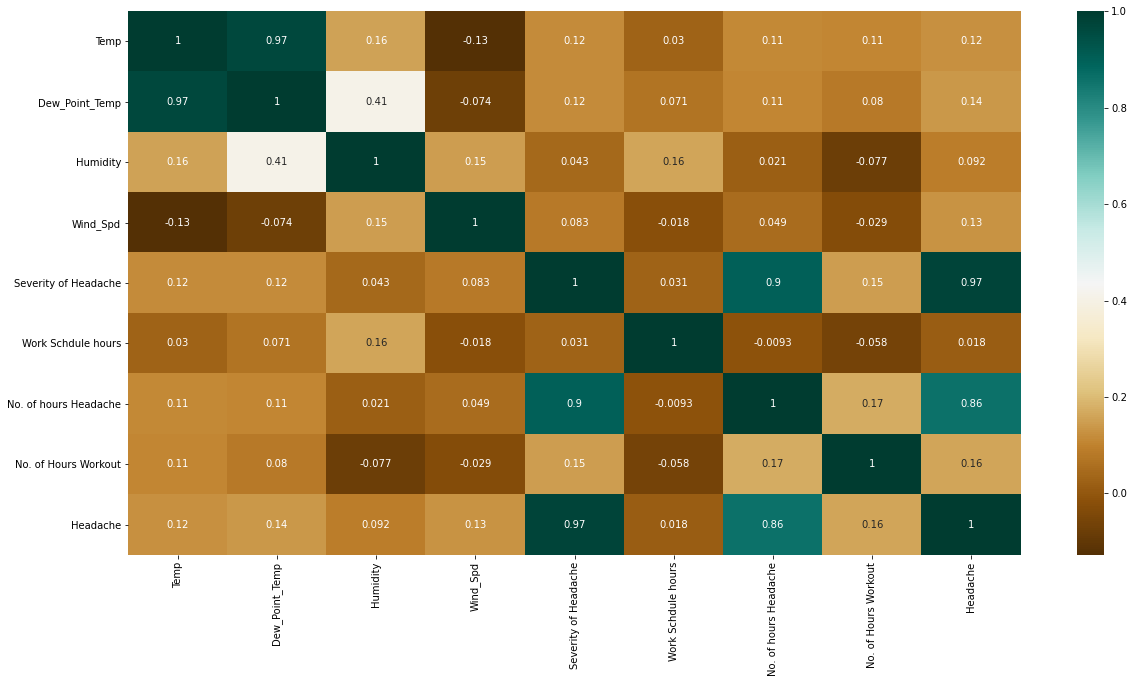

In [62]:
plt.figure(figsize =(20,10))
corr_plot = data.corr()
sns.heatmap(corr_plot, cmap = "BrBG", annot = True)
corr_plot

- By looking the above co-related plot we can see that features such as Temp and Dew_point_temp is highly correlated and we will drop one of them

- From the above plot is also cleared that the target label "Headache" is highly correlated with "severity of Headache" and "Number of hour of headache" because all the three varibales (headache, severity of headache, Number of hours of headache) represent the same thing. Hence headache and severity of headache will be dropped.

### 4.2 Finalized Features

In [63]:
data = data_journal_weather_2019
y = data_journal_weather_2019["Headache"]

In [64]:
# From the corelation plot we saw that there is high corelation between the target label "Headache" and features "severity of Headache","No. of Hours of headache" Hence they will be dropped
data = data.drop(["Date","Headache","Days","Severity of Headache","No. of hours Headache"], axis = 1)


In [65]:
param = SelectKBest(score_func = f_classif, k = 6)
data_fit = param.fit(data,y)
data_scores = pd.DataFrame(data_fit.scores_)
data_columns = pd.DataFrame(data.columns)
feature_scores_columns = pd.concat([data_columns,data_scores], axis = 1)
feature_scores_columns.columns = ["Feature","Feature_score"]


In [66]:
feature_scores_columns

,Feature,Feature_score
0,Temp,1.900727
1,Dew_Point_Temp,2.314639
2,Humidity,1.023656
3,Wind_Spd,2.036560
4,Work Schdule hours,0.037773
5,No. of Hours Workout,3.197544


##### Dropping Unnecessary Features

In [67]:
data_journal_weather_2019 = data_journal_weather_2019.drop(["Dew_Point_Temp","Date","Days","Severity of Headache","No. of hours Headache"], axis = 1)
prediction_data_journal_weather_2020 = prediction_data_journal_weather_2020.drop(["Date","Dew_Point_Temp"], axis = 1)

## 5 Model Building

#### Splitting the Data

In [68]:
X_train, X_test, y_train, y_test = train_test_split(data_journal_weather_2019.drop("Headache", axis = 1), data_journal_weather_2019["Headache"],
                                                   test_size = 0.2, random_state = 40, stratify = data_journal_weather_2019["Headache"] )

In [69]:
print("Train data shape", X_train.shape)
print("Test data shape", X_test.shape)

Train data shape (97, 5)
Test data shape (25, 5)


#### Storing column names in a list

In [70]:
a = []
var = []
j = 0

for i in X_train.columns:
    b = []
    var.append(i)
    b.append(j)
    b.append(i)
    a.append(b)
    j = j+1

In [71]:
print(a)

[[0, 'Temp'], [1, 'Humidity'], [2, 'Wind_Spd'], [3, 'Work Schdule hours'], [4, 'No. of Hours Workout']]


### 5.1 Feature Engineering

In [72]:
scaling = StandardScaler()

In [73]:
scaling.fit(X_train[var])
X_train = scaling.transform(X_train[var])
X_test = scaling.transform(X_test[var])
prediction_data_journal_weather_2020 = scaling.transform(prediction_data_journal_weather_2020 [var])

### 5.2 Decision Tree With Default Parameters

In [74]:
clf1 = DecisionTreeClassifier()

In [75]:
clf1.fit(X_train, y_train)

y_test_pred = clf1.predict(X_test)

In [69]:
print("F1 score of the model:", f1_score(y_test,y_test_pred, average ="weighted")*100)
print("Accuracy of the model:", accuracy_score(y_test,y_test_pred)*100)
print("Precision score of the model :", precision_score(y_test,y_test_pred, average ="weighted")*100)
print("Recall Score of the model :", recall_score(y_test,y_test_pred, average ="weighted")*100)
print("Confusion matrix of the model : \n", confusion_matrix(y_test,y_test_pred))

F1 score of the model: 81.77777777777779
Accuracy of the model: 80.0
Precision score of the model : 83.63636363636364
Recall Score of the model : 80.0
Confusion matrix of the model : 
 [[20  3]
 [ 2  0]]


In [79]:
#Prediction on sept 2020 data probablities
y_test_prob1 = clf1.predict_proba(prediction_data_journal_weather_2020)

In [83]:
savetxt("y_test_prob1.csv", y_test_prob1, delimiter= ",")

- Feature importance for Base line decision tree

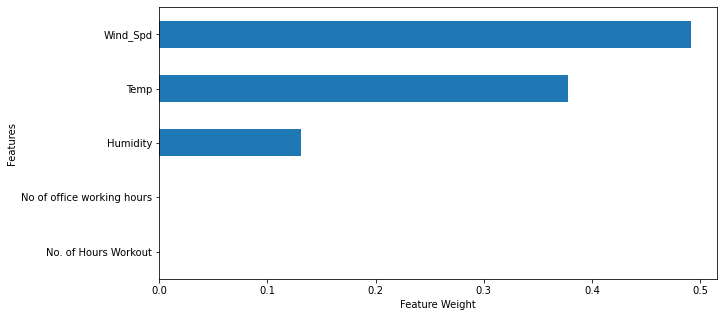

In [71]:
plt.figure(figsize = (10,5))
plt.xlabel("Feature Weight")
plt.ylabel("Features")
importance = pd.Series(clf1.feature_importances_,index = var)
importance.nlargest(20).plot(kind = 'barh').invert_yaxis()

### 5.3 Decision Tree With Hyperparameter Tuning With Class Weight As Balanced

In [84]:
max_depth = [int(x) for x in range(10)]
max_depth.append(None)
criterion = ["gini","entropy"]
min_samples_leaf = [1,2,3,4,5]
min_samples_split = [1,2,3,4,5]
max_features = [1,2,3,4,5]

In [85]:
param_grid = {"max_features": max_features,
                 "max_depth": max_depth,
                 "min_samples_leaf": min_samples_leaf,
                 "min_samples_split": min_samples_split,
                 "criterion": criterion}

In [ ]:
tree_clf = DecisionTreeClassifier(class_weight = "balanced")
tree_clf_cv = GridSearchCV(tree_clf, param_grid= param_grid, verbose = 2, cv = 5, scoring = "f1", return_train_score= True)
hyper_clf = tree_clf_cv.fit(X_train, y_train)

In [75]:
print(tree_clf_cv.best_estimator_)


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features=2, min_samples_leaf=5, min_samples_split=3)


In [87]:
clf2 =DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features=2, min_samples_leaf=5, min_samples_split=3)

In [88]:
clf2.fit(X_train, y_train)

y_test_pred = clf2.predict(X_test)

In [78]:
print("F1 score of the model:", f1_score(y_test,y_test_pred, average ="weighted")*100)
print("Accuracy of the model:", accuracy_score(y_test,y_test_pred)*100)
print("Precision score of the model :", precision_score(y_test,y_test_pred, average ="weighted")*100)
print("Recall Score of the model :", recall_score(y_test,y_test_pred, average ="weighted")*100)
print("Confusion matrix of the model : \n", confusion_matrix(y_test,y_test_pred))

F1 score of the model: 75.19999999999999
Accuracy of the model: 68.0
Precision score of the model : 87.58823529411765
Recall Score of the model : 68.0
Confusion matrix of the model : 
 [[16  7]
 [ 1  1]]


In [89]:
#Prediction on sept 2020 data probablities
y_test_prob2 = clf2.predict_proba(prediction_data_journal_weather_2020)
savetxt("y_test_prob2.csv", y_test_prob2, delimiter= ",")

- Feature importance as class weight balanced

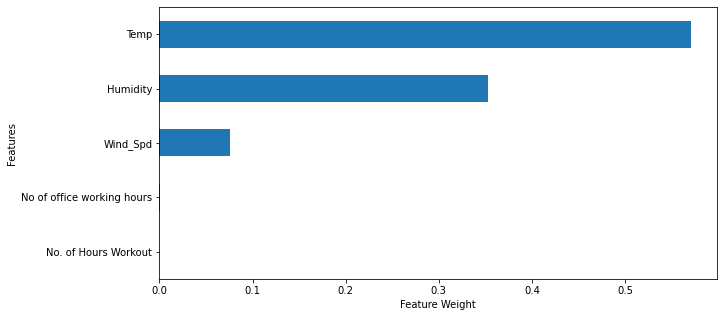

In [79]:
plt.figure(figsize = (10,5))
plt.xlabel("Feature Weight")
plt.ylabel("Features")
importance = pd.Series(clf2.feature_importances_,index = var)
importance.nlargest(20).plot(kind = 'barh').invert_yaxis()

### 5.4 Decision Tree With Oversampling of Training Data

In [91]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [81]:
max_depth = [int(x) for x in range(10)]
max_depth.append(None)
criterion = ["gini","entropy"]
min_samples_leaf = [1,2,3,4,5]
min_samples_split = [1,2,3,4,5]
max_features = [1,2,3,4,5]

In [82]:
param_grid = {"max_features": max_features,
                 "max_depth": max_depth,
                 "min_samples_leaf": min_samples_leaf,
                 "min_samples_split": min_samples_split,
                 "criterion": criterion}

In [ ]:
tree_clf = DecisionTreeClassifier(class_weight = "balanced")
tree_clf_cv = GridSearchCV(tree_clf, param_grid= param_grid, verbose = 2, cv = 5, scoring = "f1", return_train_score= True)
hyper_clf = tree_clf_cv.fit(X_train, y_train)

In [84]:
print(tree_clf_cv.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', max_features=5,
                       min_samples_split=4)


In [92]:
clf3 = DecisionTreeClassifier(class_weight='balanced', max_features=5,
                       min_samples_split=4)

In [93]:
clf3.fit(X_train, y_train)

y_test_pred = clf3.predict(X_test)

In [87]:
print("F1 score of the model:", f1_score(y_test,y_test_pred, average ="weighted")*100)
print("Accuracy of the model:", accuracy_score(y_test,y_test_pred)*100)
print("Precision score of the model :", precision_score(y_test,y_test_pred, average ="weighted")*100)
print("Recall Score of the model :", recall_score(y_test,y_test_pred, average ="weighted")*100)
print("Confusion matrix of the model : \n", confusion_matrix(y_test,y_test_pred))

F1 score of the model: 81.77777777777779
Accuracy of the model: 80.0
Precision score of the model : 83.63636363636364
Recall Score of the model : 80.0
Confusion matrix of the model : 
 [[20  3]
 [ 2  0]]


In [94]:
#Prediction on sept 2020 data probablities
y_test_prob3 = clf3.predict_proba(prediction_data_journal_weather_2020)
savetxt("y_test_prob3.csv", y_test_prob3, delimiter= ",")

- Feature importance of oversampled classifier

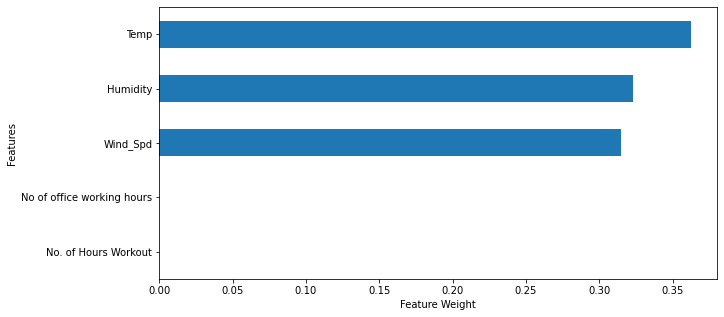

In [88]:
plt.figure(figsize = (10,5))
plt.xlabel("Feature Weight")
plt.ylabel("Features")
importance = pd.Series(clf3.feature_importances_,index = var)
importance.nlargest(20).plot(kind = 'barh').invert_yaxis()

### 5.5 Decision Tree With Undersampling of Traning Data

In [74]:
undersample = NearMiss()
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [75]:
max_depth = [int(x) for x in range(10)]
max_depth.append(None)
criterion = ["gini","entropy"]
min_samples_leaf = [1,2,3,4,5]
min_samples_split = [1,2,3,4,5]
max_features = [1,2,3,4,5]

In [71]:
param_grid = {"max_features": max_features,
                 "max_depth": max_depth,
                 "min_samples_leaf": min_samples_leaf,
                 "min_samples_split": min_samples_split,
                 "criterion": criterion}

In [ ]:
tree_clf = DecisionTreeClassifier(class_weight = "balanced")
tree_clf_cv = GridSearchCV(tree_clf, param_grid= param_grid, verbose = 2, cv = 5, scoring = "f1", return_train_score= True)
hyper_clf = tree_clf_cv.fit(X_train, y_train)

In [73]:
print(tree_clf_cv.best_estimator_)
print("Max f1 score on train data", tree_clf_cv.best_score_*100)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=1, min_samples_split=4)
Max f1 score on train data 80.0


In [76]:
clf4 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=1, min_samples_split=4)

In [78]:
clf4.fit(X_train, y_train)

y_test_pred = clf4.predict(X_test)

In [77]:
print("F1 score of the model:", f1_score(y_test,y_test_pred, average ="weighted")*100)
print("Accuracy of the model:", accuracy_score(y_test,y_test_pred)*100)
print("Precision score of the model :", precision_score(y_test,y_test_pred, average ="weighted")*100)
print("Recall Score of the model :", recall_score(y_test,y_test_pred, average ="weighted")*100)
print("Confusion matrix of the model : \n", confusion_matrix(y_test,y_test_pred))

F1 score of the model: 28.65056360708535
Accuracy of the model: 24.0
Precision score of the model : 92.76190476190476
Recall Score of the model : 24.0
Confusion matrix of the model : 
 [[ 4 19]
 [ 0  2]]


In [79]:
#Prediction on sept 2020 data probablities
y_test_prob4 = clf4.predict_proba(prediction_data_journal_weather_2020)
savetxt("y_test_prob4.csv", y_test_prob4, delimiter= ",")

- Feature Importance of undersampled classifier

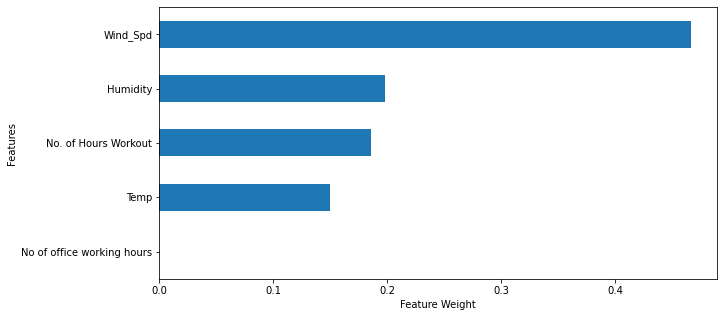

In [81]:
plt.figure(figsize = (10,5))
plt.xlabel("Feature Weight")
plt.ylabel("Features")

importance = pd.Series(clf4.feature_importances_,index = var)
importance.nlargest(20).plot(kind = 'barh').invert_yaxis()

## 6 Evaluation

In [166]:
Result_data = pd.read_excel('./Data/prediction_data_journal_weather_2020.xls')
Result_data

,Date,Temp,Dew_Point_Temp,Humidity,Wind_Spd,Work Schdule hours,No. of Hours Workout,prob_no_headache,prob_headache
0,2020-09-01,14.625,9.145,69.475,6.935,0,0,1.000000,0.00
1,2020-09-02,14.315,12.720,90.415,9.705,8,1,1.000000,0.00
2,2020-09-03,18.725,18.360,99.345,15.415,8,0,1.000000,0.00
3,2020-09-04,20.150,18.970,93.625,11.585,8,1,1.000000,0.00
4,2020-09-05,19.030,12.085,66.875,9.750,8,0,0.082474,0.92
5,2020-09-06,17.180,9.860,65.455,8.580,8,1,0.082474,0.92
6,2020-09-07,15.820,14.645,91.230,8.645,0,0,1.000000,0.00
7,2020-09-08,19.535,17.655,88.940,6.790,0,0,1.000000,0.00
8,2020-09-09,18.640,17.325,90.605,5.455,8,0,1.000000,0.00
9,2020-09-10,20.470,20.360,99.000,6.435,8,0,1.000000,0.00


In [ ]:
data = pd.DataFrame(columns=["Date","Headache"])
data["Headache"] = Result_data["prob_headache"]
data["Date"] = Result_data["Date"]
data['Date']=pd.to_datetime(data['Date']).dt.strftime('%d')
data['Date'] = data.to_numeric(data['Date'],errors='coerce')


plt.figure(figsize = (12,5))
ax = sns.lineplot(x="Date",data = data, hue="Headache")

### Model Prediction And Temperature

In [ ]:
data = pd.DataFrame(columns=["Date","Headache","Temp"])
Result_data.loc[Result_data.prob_headache > 0.7, 'Headache'] = 1
Result_data.loc[Result_data.prob_headache <= 0.7, 'Headache'] = 0
data["Headache"] = Result_data["Headache"]
data["Date"] = Result_data["Date"]
data["Temp"] = Result_data["Temp"]
data['Date']=pd.to_datetime(data['Date']).dt.strftime('%d')
plt.figure(figsize = (12,5))
ax = sns.lineplot(x="Date", y="Temp",data = data,color="green")
ax2 = ax.twinx()
sns.scatterplot(x="Date", y="Headache",data = data, ax=ax2, hue="Headache")
ax.axhline(data["Temp"].mean(), ls='--', color="red")

### Model Prediction And Humidity

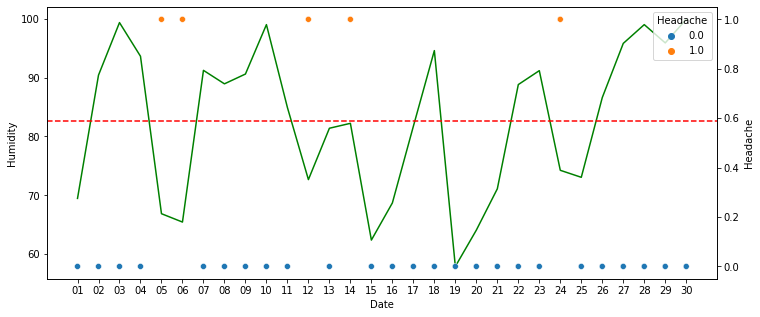

In [160]:
data = pd.DataFrame(columns=["Date","Headache","Humidity"])
Result_data.loc[Result_data.prob_headache > 0.7, 'Headache'] = 1
Result_data.loc[Result_data.prob_headache <= 0.7, 'Headache'] = 0
data["Headache"] = Result_data["Headache"]
data["Date"] = Result_data["Date"]
data["Humidity"] = Result_data["Humidity"]
data['Date']=pd.to_datetime(data['Date']).dt.strftime('%d')
plt.figure(figsize = (12,5))
ax = sns.lineplot(x="Date", y="Humidity",data = data, color="green")
ax2 = ax.twinx()
sns.scatterplot(x="Date", y="Headache",data = data, ax=ax2, hue="Headache")
ax.axhline(data["Humidity"].mean(), ls='--', color="red")

### Model Prediction And Wind Speed

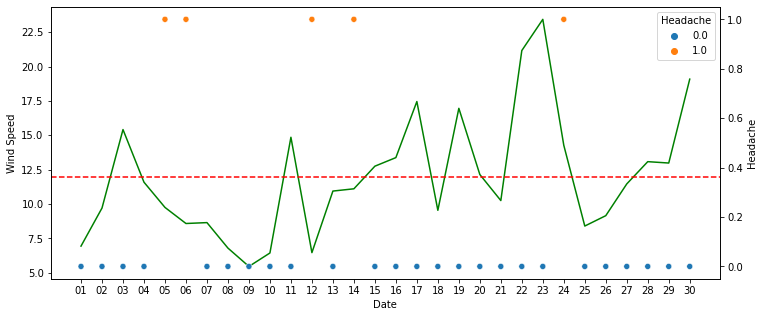

In [161]:
data = pd.DataFrame(columns=["Date","Headache","Wind Speed"])
Result_data.loc[Result_data.prob_headache > 0.7, 'Headache'] = 1
Result_data.loc[Result_data.prob_headache <= 0.7, 'Headache'] = 0
data["Headache"] = Result_data["Headache"]
data["Date"] = Result_data["Date"]
data["Wind Speed"] = Result_data["Wind_Spd"]
data['Date']=pd.to_datetime(data['Date']).dt.strftime('%d')
plt.figure(figsize = (12,5))
ax = sns.lineplot(x="Date", y="Wind Speed",data = data, color="green")
ax2 = ax.twinx()
sns.scatterplot(x="Date", y="Headache",data = data, ax=ax2, hue="Headache")
ax.axhline(data["Wind Speed"].mean(), ls='--', color="red")

### Model Prediction And Work Schedule Hours

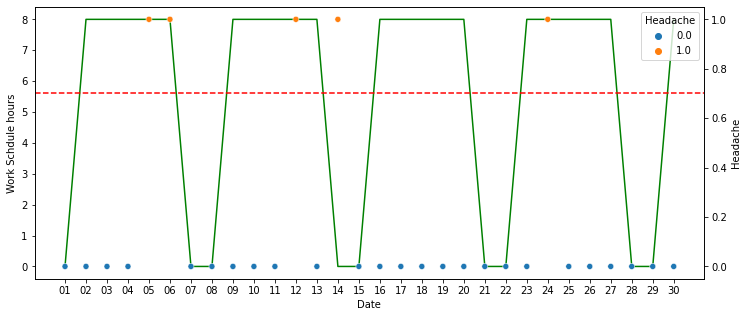

In [162]:
data = pd.DataFrame(columns=["Date","Headache","Work Schdule hours"])
Result_data.loc[Result_data.prob_headache > 0.7, 'Headache'] = 1
Result_data.loc[Result_data.prob_headache <= 0.7, 'Headache'] = 0
data["Headache"] = Result_data["Headache"]
data["Date"] = Result_data["Date"]
data["Work Schdule hours"] = Result_data["Work Schdule hours"]
data['Date']=pd.to_datetime(data['Date']).dt.strftime('%d')
plt.figure(figsize = (12,5))
ax = sns.lineplot(x="Date", y="Work Schdule hours",data = data, color="green")
ax2 = ax.twinx()
sns.scatterplot(x="Date", y="Headache",data = data, ax=ax2, hue="Headache")
ax.axhline(data["Work Schdule hours"].mean(), ls='--', color="red")

### Model Prediction And No. of Hours Workout

In [ ]:
data = pd.DataFrame(columns=["Date","Headache","No. of Hours Workout"])
Result_data.loc[Result_data.prob_headache > 0.7, 'Headache'] = 1
Result_data.loc[Result_data.prob_headache <= 0.7, 'Headache'] = 0
data["Headache"] = Result_data["Headache"]
data["Date"] = Result_data["Date"]
data["No. of Hours Workout"] = Result_data["No. of Hours Workout"]
data['Date']=pd.to_datetime(data['Date']).dt.strftime('%d')
plt.figure(figsize = (12,5))
ax = sns.lineplot(x="Date", y="No. of Hours Workout",data = data, color="green")
ax2 = ax.twinx()
sns.scatterplot(x="Date", y="Headache",data = data, ax=ax2, hue="Headache")
ax.axhline(data["No. of Hours Workout"].mean(), ls='--', color="red")

In [ ]:
def prediction_against_factor(factor_name, Result_data): 
    data = pd.DataFrame(columns=["Date","Headache",factor_name])
    Result_data.loc[Result_data.prob_headache > 0.7, 'Headache'] = 1
    Result_data.loc[Result_data.prob_headache <= 0.7, 'Headache'] = 0
    data["Headache"] = Result_data["Headache"]
    data["Date"] = Result_data["Date"]
    data[factor_name] = Result_data[factor_name]
    data['Date']=pd.to_datetime(data['Date']).dt.strftime('%d')
    plt.figure(figsize = (12,5))
    ax = sns.lineplot(x="Date", y=factor_name,data = data, color="green")
    ax2 = ax.twinx()
    sns.scatterplot(x="Date", y="Headache",data = data, ax=ax2, hue="Headache")
    ax.axhline(data[factor_name].mean(), ls='--', color="red")